# Sarcasm classification

Natural language processing notebook to classify news headlines as sarcastic or not.

Dataset:

*   from kaggle - https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home
*   News headlines from The Onion = sarcastic
*   News headlines from Huffington Post = not sarcastic

Notebook summary:
*   News headlines are sentences
*   Convert to word tokens
*   Convert to vocab of integers
*   Training matrix is generated by padding the sentences to the same length
*   Train model to
    *   convert vocab integers to vector embeddings
    *   average the embedding vectors per sentence
    *   then to single class to suggest is sarcastic
*   Model trained to minimise binary cross entropy loss
*   Plots ROC/PR curves to check overfitting

References:

*   https://www.youtube.com/watch?v=Y_hzMnRXjhI
*   https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html

First we load the data into a torch dataset which requires the `__len__` and `__get_item__` methods.

In [1]:
import torch
import json
from pathlib import Path
import random


class SarcasmData(torch.utils.data.dataset.Dataset):
    """Load sentiment data. Takes only headline and sentiment from data."""

    def __init__(
        self,
        filepath: Path,
    ):
        self.sentences = []
        self.labels = []

        with open(filepath, "r") as f:
            for line in f:
                json_contents = json.loads(line)
                self.sentences.append(json_contents["headline"])
                self.labels.append(json_contents["is_sarcastic"])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.sentences[index], self.labels[index]


# assumes data is already downloaded from kaggle to the following path
full_dataset = SarcasmData(
    filepath=Path("data/Sarcasm_Headlines_Dataset.json").absolute()
)

# split train and test sets
num_train = int(len(full_dataset) * 0.8)
train_dataset, test_dataset = torch.utils.data.dataset.random_split(
    full_dataset,
    [num_train, len(full_dataset) - num_train],
    generator=torch.Generator().manual_seed(42),
)

# get a random row of the dataset
x, y = train_dataset[random.randint(0, len(train_dataset))]
x, y

('how to write a thank you that gets you hired', 0)

Convert the headline sentences into word tokens

In [2]:
# normalise string to tokens
# build tokenizer to take sentence and split to List[str]
# build vocab to generate List[int]

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = iter(train_dataset)


def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], min_freq=3
)
vocab.set_default_index(vocab["<unk>"])

vocab(["here", "is", "an", "example"])
vocab(tokenizer(x))

print(f"Vocab length: {len(vocab)}")

Vocab length: 9030


Build pipelines to transform a data tuple into appropriate training vectors and labels.

In [3]:
import numpy as np

max_seq_length = 100
cost_fcn = "bin"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def text_pipeline(text):
    """Take a text sentence, convert to vocab integers and pad with 0s to the same length."""

    text_tokens = vocab(tokenizer(text[:max_seq_length]))
    padded_tokens = np.zeros((1, max_seq_length), dtype=np.int64)
    padded_tokens[0, 0 : len(text_tokens)] = text_tokens
    return torch.from_numpy(padded_tokens)


def label_pipeline(label):
    return torch.tensor([label])


def collate_batch(batch):
    """Transform batch from dataset for the text/label pipelines.
    Creates numpy array of text tokens and labels.
    Use only the first N word token"""

    token_list = []
    label_list = []
    for _text, _label in batch:
        token_list.append(text_pipeline(_text))
        label_list.append(label_pipeline(_label))

    if cost_fcn == "bin":
        # class probs
        labels = torch.cat(label_list).type(torch.DoubleTensor)[:, None]
    else:
        # class indices
        labels = torch.cat(label_list).type(torch.int64)
    text_tokens = torch.cat(token_list, dim=0)

    return text_tokens.to(device), labels.to(device)


Create dataloaders to process the data via the collate function. Dataloaders are required to feed the data into Pytorch lightning for training.
We further split the training dataset to a train and validation set so we can apply early stopping.

In [4]:
BATCH_SIZE = 64

num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = torch.utils.data.dataset.random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train],
    generator=torch.Generator().manual_seed(42),
)

train_dataloader = torch.utils.data.DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = torch.utils.data.DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

text_tokens, labels = next(iter(train_dataloader))

print(f"text token shape: {text_tokens.shape}")
print(f"labels shape: {labels.shape}")


text token shape: torch.Size([64, 100])
labels shape: torch.Size([64, 1])


Create the model definition.
We use an `EmbeddingBag` to take the padded sentences and convert to embedding vectors.
We then take the mean of the vectors to give a single average vector, of dimension equal to the embedding size.

The loss function is set to binary cross entropy as we have a single binary output class to predict. This requires the target labels to be of type `float`. This is different to `CrossEntropyLoss` where the labels are the class index and are set as integers. They also require the labels to be a single vector ([N]), rather than a vector per training row ([N x 1]).
This is setup in the `collate_batch` function.

In [5]:
import pytorch_lightning as pl


class TextClassificationModelPL(pl.LightningModule):
    def __init__(
        self,
        vocab_size,
        embed_size,
        num_class,
        learning_rate=1e-3,
    ):
        super().__init__()
        self.embedding = torch.nn.EmbeddingBag(
            num_embeddings=vocab_size, embedding_dim=embed_size, mode="mean"
        )

        self.fc1 = torch.nn.Linear(embed_size, 24)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(24, num_class)

        self.train_log_error = []
        self.val_log_error = []
        self.learning_rate = learning_rate
        self.loss = torch.nn.BCEWithLogitsLoss()  # requires one output column
        # self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, text_tokens):
        embedded = self.embedding(text_tokens)
        fc1ed = self.fc1(embedded)
        relued = self.relu(fc1ed)
        return self.fc2(relued)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        (text_tokens, labels) = batch

        output = self.forward(text_tokens)
        loss = self.loss(output, labels)

        self.train_log_error.append(loss.detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        (text_tokens, labels) = batch

        output = self.forward(text_tokens)
        loss = self.loss(output, labels)

        self.log("val_loss", loss, on_epoch=True)
        self.val_log_error.append(loss.detach().numpy())
        return loss


In [6]:
from torchinfo import summary

num_class = 1 if cost_fcn == "bin" else 2
vocab_size = len(vocab)
embed_size = 16
model = TextClassificationModelPL(
    vocab_size=vocab_size, embed_size=embed_size, num_class=num_class
).to(device)

# setup dummy input data to get dimensions of layer outputs
tokens = [[7, 43, 67, 7, 43, 68], [1, 2, 3, 4, 5, 6]]
summary(model, input_data=(torch.tensor(tokens)))


Layer (type:depth-idx)                   Output Shape              Param #
TextClassificationModelPL                --                        --
├─EmbeddingBag: 1-1                      [2, 16]                   144,480
├─Linear: 1-2                            [2, 24]                   408
├─ReLU: 1-3                              [2, 24]                   --
├─Linear: 1-4                            [2, 1]                    25
├─BCEWithLogitsLoss: 1-5                 --                        --
Total params: 144,913
Trainable params: 144,913
Non-trainable params: 0
Total mult-adds (M): 0.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.58
Estimated Total Size (MB): 0.58

In [20]:
# train
import matplotlib.pyplot as plt
import numpy as np

# fit network
trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=30)
    ],
)
trainer.fit(model, train_dataloader, valid_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type              | Params
------------------------------------------------
0 | embedding | EmbeddingBag      | 144 K 
1 | fc1       | Linear            | 408   
2 | relu      | ReLU              | 0     
3 | fc2       | Linear            | 25    
4 | loss      | BCEWithLogitsLoss | 0     
------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.580     Total estimated model params size (MB)


/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the numbe

Epoch 29: 100%|██████████| 335/335 [00:03<00:00, 96.76it/s, loss=0.0166, v_num=27]  


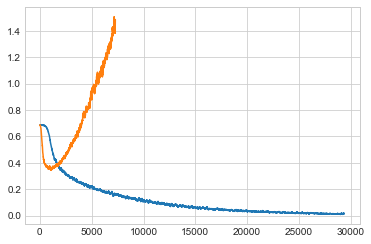

In [21]:
# plot training loss
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


plt.plot(moving_average(np.array(model.train_log_error)))
plt.plot(moving_average(np.array(model.val_log_error)))

## Validating results

Checking some individual predictions from the train/validiation/test datasets.

In [9]:
import random


def predict_text(text: str):
    with torch.no_grad():
        log_probit = model(text_pipeline(text))
    if cost_fcn == "bin":
        proba = torch.nn.Sigmoid()(log_probit).item()
    else:
        proba = torch.nn.Softmax(dim=1)(log_probit)[0][1].item()

    print(text)
    print("p(is sarcastic)= ", proba)


def check_prediction(data_tuple):
    predict_text(data_tuple[0])
    print("is sarcastic: ", data_tuple[1])
    print("--------------")

random.seed(0)
check_prediction(split_train_[random.randint(0, len(split_train_))])
check_prediction(split_valid_[random.randint(0, len(split_valid_))])
check_prediction(test_dataset[random.randint(0, len(test_dataset))])


nemesis lands alumni magazine cover
p(is sarcastic)=  0.9891561269760132
is sarcastic:  1
--------------
john legend gushing about chrissy teigen and baby luna is just the cutest
p(is sarcastic)=  0.0021374858915805817
is sarcastic:  0
--------------
meatless monday: the seed of something great -- seed food and wine festival
p(is sarcastic)=  0.0051068514585494995
is sarcastic:  0
--------------


In [10]:
# validating results
def predict_whole_dataloader(dataloader, prob_output: bool = True):
    dataloader = torch.utils.data.DataLoader(
        dataset=dataloader.dataset,
        batch_size=len(dataloader.dataset),
        collate_fn=collate_batch,
    )
    (text_tokens, labels) = next(iter(dataloader))

    with torch.no_grad():
        output = model.forward(text_tokens)

    if cost_fcn == "bin":
        output = torch.nn.Sigmoid()(output)
    else:
        output = torch.nn.Softmax(dim=1)(output)

    if not prob_output:
        if cost_fcn == "bin":
            # assume 0.5 prob threshold
            output = output > 0.5
        else:
            output = output.argmax(1)

    return output, labels


dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
    "test": test_dataloader,
}

Model loss and accuracy on the whole datasets shows a reasonable accuracy of >80% and we are not overfitting significantly.

In [11]:
# test performance
def evaluate(dataloader):
    output, labels = predict_whole_dataloader(dataloader, prob_output=True)
    loss = model.loss(output, labels)

    output, labels = predict_whole_dataloader(dataloader, prob_output=False)
    accuracy = ((output == labels).sum() / len(labels)).item()
    print(f"model loss, accuracy = {loss:8.3f}, {accuracy:8.3f}")

    return loss, accuracy


for name, dataloader in dataloaders.items():
    print(f"Checking the results of {name} dataset.")
    evaluate(dataloader)


Checking the results of train dataset.
model loss, accuracy =    0.587,    0.925
Checking the results of valid dataset.
model loss, accuracy =    0.616,    0.844
Checking the results of test dataset.
model loss, accuracy =    0.621,    0.851


### Save results for later processing

In [15]:
import pandas as pd

for name, dataloader in dataloaders.items():
    print(f"Checking the results of {name} dataset.")
    evaluate(dataloader)
    output, labels = predict_whole_dataloader(dataloader, prob_output=True)

Checking the results of train dataset.
model loss, accuracy =    0.587,    0.925
Checking the results of valid dataset.
model loss, accuracy =    0.616,    0.844
Checking the results of test dataset.
model loss, accuracy =    0.621,    0.851


,0
0,0.294776
1,0.819845
2,0.999552
3,0.016700
4,0.033806
...,...
5337,0.067428
5338,0.319066
5339,0.169987
5340,0.005426


### Other diagnostics

The precision-recall and ROC curves are plotted by varying the threshold for a positive classification. They give a more robust representation of performance in the case of unbalanced classes.
They show as we increase the threshold for a positive class label from 0 -> 1, how does this trade off true positives vs false positives, e.g. detecting nothing as sarcastic through to detecting everything as sarcastic.

ROC - a random classifier has a straight line on the diagonal. Better performance is seen for classifiers with a larger area under the curve (AUC).

Text(0.5, 1.0, 'ROC curve')

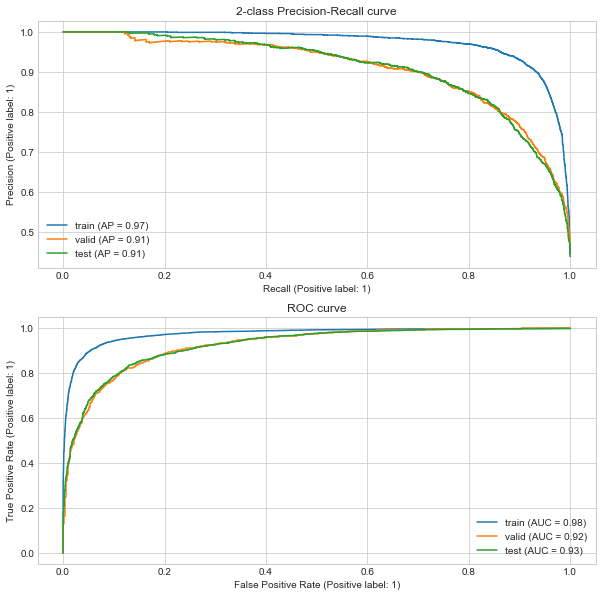

In [12]:
import sklearn.metrics

fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
for name, dataloader in dataloaders.items():
    proba, labels = predict_whole_dataloader(dataloader)
    display = sklearn.metrics.PrecisionRecallDisplay.from_predictions(
        y_true=labels, y_pred=proba, name=name, ax=ax[0]
    )
    display = sklearn.metrics.RocCurveDisplay.from_predictions(
        y_true=labels, y_pred=proba, name=name, ax=ax[1]
    )
ax[0].set_title("2-class Precision-Recall curve")
ax[1].set_title("ROC curve")


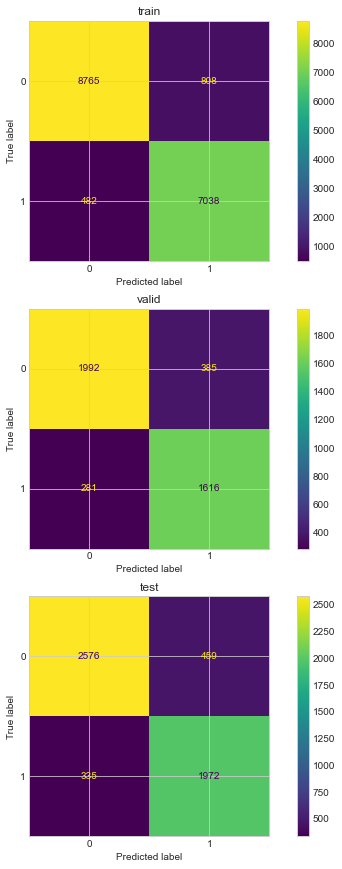

In [13]:
# confusion matrix
fig, ax = plt.subplots(figsize=(10, 5 * len(dataloaders)), nrows=len(dataloaders))
for idx, (name, dataloader) in enumerate(dataloaders.items()):
    output, labels = predict_whole_dataloader(dataloader, prob_output=False)

    cm = sklearn.metrics.confusion_matrix(y_true=labels, y_pred=output)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(cm).plot(ax=ax[idx])
    ax[idx].set_title(name)
